# Trabajo Práctico 2 - Organización de Datos
## Competencia de Machine Learning
### Facultad de Ingeniería de la Universidad de Buenos Aires
### 95-58: Organización de Datos - 2do Cuat. 2018

#### Integrantes: Gonzalo Diz,  Ariel Windey, Gabriel Robles y Matías El Dócil




#### Objetivo
Determinar, para cada usuario presentado, cuál es la probabilidad de que ese
usuario realice una conversión en Trocafone en un periodo determinado.

#### Fuentes
El archivo "events_up_to_01062018.csv" contiene en el mismo formato utilizado en el TP1
información de eventos realizado en la plataforma para un conjunto de usuarios hasta el
31/05/2018.

Por otro lado el archivo "labels_training_set.csv" indica para un subconjunto de los
usuarios incluidos en el set de eventos "events_up_to_01062018.csv" si los mismos
realizaron una conversión (columna label = 1) o no (columna label = 0) desde el 01/06/2018
hasta el 15/06/2018.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [2]:
# Carga del set de datos de eventos
eventos = pd.read_csv('../dataset/events_up_to_01062018.csv', low_memory=False)
# Carga del set de datos de labels
labels = pd.read_csv('../dataset/labels_training_set.csv', low_memory=False)


In [3]:
eventos.shape

(2341681, 23)

In [4]:
eventos.event.value_counts()

viewed product       1248124
brand listing         216312
visited site          204069
ad campaign hit       191388
generic listing       160176
searched products     130616
search engine hit     106406
checkout               65315
staticpage             11201
conversion              7091
lead                     983
Name: event, dtype: int64

In [5]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
414399,2018-05-27 14:57:00,checkout,497d1e47,NaN,7658.0,Lenovo Vibe A7010 Dual Chip,Muito Bom,32GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1540926,2018-05-31 19:11:40,viewed product,bfabd778,NaN,3661.0,iPhone 5c,Excelente,8GB,Rosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436211,2018-05-31 10:40:32,viewed product,25caf64f,NaN,9302.0,Samsung Galaxy J5 Prime,Excelente,32GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929100,2018-05-28 02:47:10,searched products,9e86c41c,NaN,NaN,NaN,NaN,NaN,NaN,"10476,10463,10393,10365,10408,10350,10420,1043...",Moto g4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1360225,2018-03-05 10:45:40,viewed product,2b02eb70,NaN,12073.0,Samsung Galaxy S7 Edge,Muito Bom,32GB,Olympic Edition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Agregamos campos de fecha como en el TP 1
eventos['timestamp'] = pd.to_datetime(eventos['timestamp'])
eventos['hour'] = eventos['timestamp'].dt.hour
eventos['month'] = eventos['timestamp'].dt.month
eventos['week_year'] = eventos['timestamp'].dt.weekofyear
eventos['week'] = eventos['timestamp'].dt.week
eventos['year'] = eventos['timestamp'].dt.year
eventos['day_week'] = eventos['timestamp'].dt.dayofweek
eventos['month_day'] = eventos['timestamp'].dt.day

In [7]:
# Obtenemos un frame con solo los usuarios donde iremos mergeando los features
persons = eventos.person.to_frame().drop_duplicates()

### Región geográfica
Agregamos la región geográfica al igual que en el TP 1, para saber desde donde acceden más los distintos usuarios.

In [8]:
# Categorizamos las regiones geograficamente
eventos['geo_region'] = 0

eventos.loc[
    (eventos['region'] == 'Sao Paulo') |
    (eventos['region'] == 'Rio de Janeiro') |
    (eventos['region'] == 'Minas Gerais') |
    (eventos['region'] == 'Espirito Santo'), 
    'geo_region'
] = 'southeast'

eventos.loc[
    (eventos['region'] == 'Parana') |
    (eventos['region'] == 'Rio Grande do Sul') |
    (eventos['region'] == 'Santa Catarina'), 
    'geo_region'
] = 'south'

eventos.loc[
    (eventos['region'] == 'Federal District') |
    (eventos['region'] == 'Goias') |
    (eventos['region'] == 'Mato Grosso do Sul') |
    (eventos['region'] == 'Mato Grosso'), 
    'geo_region'
] = 'center west'

eventos.loc[
    (eventos['region'] == 'Bahia') |
    (eventos['region'] == 'Pernambuco') |
    (eventos['region'] == 'Ceara') |
    (eventos['region'] == 'Maranhao') |
    (eventos['region'] == 'Rio Grande do Norte') |
    (eventos['region'] == 'Paraíba') |
    (eventos['region'] == 'Piaui') |
    (eventos['region'] == 'Alagoas') |
    (eventos['region'] == 'Sergipe'), 
    'geo_region'
] = 'northeast'

eventos.loc[
    (eventos['region'] == 'Para') |
    (eventos['region'] == 'Amazonas') |
    (eventos['region'] == 'Tocantins') |
    (eventos['region'] == 'Amapa') |
    (eventos['region'] == 'Rondonia') |
    (eventos['region'] == 'Acre') |
    (eventos['region'] == 'Roraima'), 
    'geo_region'
] = 'north'

In [9]:
eventos.geo_region.value_counts()

0              2172865
southeast        97323
northeast        40903
south            14242
center west       9249
north             7099
Name: geo_region, dtype: int64

Creamos columnas booleanas sobre las regiones geograficas para luego agrupar por usuarios.

In [10]:
eventos['cant_accesos_southeast'] = (eventos.geo_region == 'southeast').astype(int)
eventos['cant_accesos_northeast'] = (eventos.geo_region == 'northeast').astype(int)
eventos['cant_accesos_south'] = (eventos.geo_region == 'south').astype(int)
eventos['cant_accesos_center_west'] = (eventos.geo_region == 'center west').astype(int)
eventos['cant_accesos_north'] = (eventos.geo_region == 'north').astype(int)

In [11]:
personas_y_accesos_por_region = eventos.groupby(['person']).agg({
    'cant_accesos_southeast': 'sum', 
    'cant_accesos_northeast': 'sum', 
    'cant_accesos_south': 'sum', 
    'cant_accesos_center_west': 'sum', 
    'cant_accesos_north': 'sum'
}).reset_index()
personas_y_accesos_por_region.head(5)

,person,cant_accesos_north,cant_accesos_center_west,cant_accesos_southeast,cant_accesos_south,cant_accesos_northeast
0,0008ed71,0,0,0,0,0
1,00091926,0,0,0,34,0
2,00091a7a,0,0,1,0,0
3,000ba417,0,0,6,0,0
4,000c79fe,0,0,1,0,0


Agregamos este nuevo feature a nuestro dataframe de features.

In [12]:
user_features = persons.merge(personas_y_accesos_por_region, how='inner', on='person')
user_features.head(5)

,person,cant_accesos_north,cant_accesos_center_west,cant_accesos_southeast,cant_accesos_south,cant_accesos_northeast
0,4886f805,0,0,1,0,0
1,ad93850f,0,0,5,0,0
2,0297fc1e,0,0,95,0,0
3,2d681dd8,0,0,2,0,0
4,cccea85e,0,0,22,0,0


In [13]:
personas_y_times = eventos.groupby(['person']).agg({
    'timestamp': ['min', 'max']
})
personas_y_times.reset_index(inplace=True)
personas_y_times.columns = ['person', 'time_first_event', 'time_last_event']
personas_y_times.head()

,person,time_first_event,time_last_event
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07


Agrego la cantidad de días al primer evento del año del usuario, usando como fecha para calcular las diferencias el 1 de junio de 2018 (dato del enunciado).

In [14]:
last_date = pd.to_datetime("2018/06/01")
personas_y_times['how_long_ago_was_first_event'] = (last_date - personas_y_times.time_first_event)
personas_y_times['how_long_ago_was_last_event'] = (last_date - personas_y_times.time_last_event)
personas_y_times['first_and_last_event_distance'] = (personas_y_times.time_last_event - personas_y_times.time_first_event)
personas_y_times.head()

,person,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37,14 days 11:32:13,14 days 07:31:23,0 days 04:00:50
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03,28 days 01:51:31,0 days 04:07:57,27 days 21:43:34
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58,66 days 09:08:49,66 days 09:03:02,0 days 00:05:47
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22,14 days 12:48:15,5 days 10:50:38,9 days 01:57:37
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07,2 days 23:32:13,2 days 23:21:53,0 days 00:10:20


Queremos ver la frecuencia de eventos de los usuarios y para ello queremos saber la cantidad total de eventos que genero cada usuario


In [15]:
# Agrego cantidad total de eventos que hizo cada usuario
eventos['cant_total_eventos'] = 1
cant_total_eventos_por_usuario = eventos.groupby(['person']).agg({'cant_total_eventos': 'sum'}).reset_index()
cant_total_eventos_por_usuario.head()

,person,cant_total_eventos
0,0008ed71,6
1,00091926,448
2,00091a7a,10
3,000ba417,206
4,000c79fe,17


In [16]:
personas_times_y_eventos_totales = personas_y_times.merge(cant_total_eventos_por_usuario, how='inner', on='person')
personas_times_y_eventos_totales.head()

,person,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37,14 days 11:32:13,14 days 07:31:23,0 days 04:00:50,6
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03,28 days 01:51:31,0 days 04:07:57,27 days 21:43:34,448
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58,66 days 09:08:49,66 days 09:03:02,0 days 00:05:47,10
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22,14 days 12:48:15,5 days 10:50:38,9 days 01:57:37,206
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07,2 days 23:32:13,2 days 23:21:53,0 days 00:10:20,17


Pasamos la distancia entre el primer y el último evento del usuario a "días" (sumando 1 para los casos que hay 0 días de distancia). Con esto podremos dividir la cantidad de eventos totales sobre esta distancia para obtener la "cantidad promedio de eventos por día por usuario".

In [17]:
personas_times_y_eventos_totales['first_and_last_event_distance_in_days'] = personas_times_y_eventos_totales.first_and_last_event_distance.dt.days + 1
personas_times_y_eventos_totales['mean_events_per_day'] = personas_times_y_eventos_totales.cant_total_eventos / personas_times_y_eventos_totales.first_and_last_event_distance_in_days
personas_times_y_eventos_totales.head()

,person,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37,14 days 11:32:13,14 days 07:31:23,0 days 04:00:50,6,1,6.0
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03,28 days 01:51:31,0 days 04:07:57,27 days 21:43:34,448,28,16.0
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58,66 days 09:08:49,66 days 09:03:02,0 days 00:05:47,10,1,10.0
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22,14 days 12:48:15,5 days 10:50:38,9 days 01:57:37,206,10,20.6
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07,2 days 23:32:13,2 days 23:21:53,0 days 00:10:20,17,1,17.0


In [18]:
user_features2 = user_features.merge(personas_times_y_eventos_totales, how='inner', on='person')
# user_features2.to_csv('../dataset/features_ariel.csv')

Analizaremos la franja horaria de mayor uso de caso usuario. Para ello haremos la siguiente categorización de los eventos:
* Accesos de 00:00hs a 05:59hs serán **madrugada**
* Accesos de 06:00hs a 11:59hs serán **mañana**
* Accesos de 12:00hs a 17:59hs serán **tarde**
* Accesos de 18:00hs a 23:59hs serán **noche**


In [19]:
eventos['cant_ev_madrugada'] = ((eventos.hour >= 0) & (eventos.hour < 7)).astype(int)
eventos['cant_ev_manana'] = ((eventos.hour >= 7) & (eventos.hour < 12)).astype(int)
eventos['cant_ev_tarde'] = ((eventos.hour >= 12) & (eventos.hour < 18)).astype(int)
eventos['cant_ev_noche'] = ((eventos.hour >= 18) & (eventos.hour < 24)).astype(int)

In [20]:
eventos.cant_ev_madrugada.value_counts()

0    1815212
1     526469
Name: cant_ev_madrugada, dtype: int64

In [21]:
eventos.cant_ev_manana.value_counts()

0    2182460
1     159221
Name: cant_ev_manana, dtype: int64

In [22]:
eventos.cant_ev_tarde.value_counts()

0    1524261
1     817420
Name: cant_ev_tarde, dtype: int64

In [23]:
eventos.cant_ev_noche.value_counts()

0    1503110
1     838571
Name: cant_ev_noche, dtype: int64

In [24]:
df = eventos.groupby(['person']).agg({
    'cant_ev_madrugada': 'sum',
    'cant_ev_manana': 'sum',
    'cant_ev_tarde': 'sum',
    'cant_ev_noche': 'sum'
})
df['franja_horaria_moda'] = df.idxmax(axis=1)
usuarios_y_cant_eventos_por_franja_horaria = df.reset_index()
usuarios_y_cant_eventos_por_franja_horaria.head()

,person,cant_ev_madrugada,cant_ev_tarde,cant_ev_manana,cant_ev_noche,franja_horaria_moda
0,0008ed71,0,6,0,0,cant_ev_tarde
1,00091926,313,0,0,135,cant_ev_madrugada
2,00091a7a,0,10,0,0,cant_ev_tarde
3,000ba417,0,149,57,0,cant_ev_tarde
4,000c79fe,17,0,0,0,cant_ev_madrugada


In [25]:
usuarios_y_cant_eventos_por_franja_horaria.franja_horaria_moda.value_counts()

cant_ev_tarde        14222
cant_ev_noche        13838
cant_ev_madrugada     8632
cant_ev_manana        2137
Name: franja_horaria_moda, dtype: int64

In [26]:
user_features3 = user_features2.merge(usuarios_y_cant_eventos_por_franja_horaria, how='inner', on='person')
user_features3
# user_features3.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_north,cant_accesos_center_west,cant_accesos_southeast,cant_accesos_south,cant_accesos_northeast,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_tarde,cant_ev_manana,cant_ev_noche,franja_horaria_moda
0,4886f805,0,0,1,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada
1,ad93850f,0,0,5,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada
2,0297fc1e,0,0,95,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,202,45,169,cant_ev_tarde
3,2d681dd8,0,0,2,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche
4,cccea85e,0,0,22,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,120,0,561,cant_ev_noche
5,4c8a8b93,0,0,20,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,81,2,67,cant_ev_madrugada
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,0,2,15,cant_ev_noche
7,29ebb414,0,0,4,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,9,0,6,cant_ev_madrugada
8,de8fe91b,0,0,2,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada


Analizaremos ahora el estado de los dispotivos moda de cada usuario

In [27]:
eventos.condition.value_counts()

Bom                   547617
Excelente             378697
Muito Bom             359053
Bom - Sem Touch ID     31742
Novo                    3421
Name: condition, dtype: int64

Agregaremos las columnas de cantidad de eventos para las distintas condiciones de los productos, para luego agrupar por usuario y sumar los totales.

In [28]:
eventos['cant_buenos'] = ((eventos.condition == 'Bom') | (eventos.condition == 'Bom - Sem Touch ID')).astype(int)
eventos['cant_excelentes'] = (eventos.condition == 'Excelente').astype(int)
eventos['cant_muy_buenos'] = (eventos.condition == 'Muito Bom').astype(int)
eventos['cant_nuevos'] = (eventos.condition == 'Novo').astype(int)

In [29]:
df = eventos.groupby(['person']).agg({
    'cant_buenos': 'sum',
    'cant_excelentes': 'sum',
    'cant_muy_buenos': 'sum',
    'cant_nuevos': 'sum'
})
df['condicion_de_producto_moda'] = df.idxmax(axis=1)
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_buenos') , 
    'condicion_de_producto_moda'
] = 'buenos'
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_excelentes') , 
    'condicion_de_producto_moda'
] = 'excelentes'
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_muy_buenos') , 
    'condicion_de_producto_moda'
] = 'muy buenos'
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_nuevos') , 
    'condicion_de_producto_moda'
] = 'nuevos'
usuarios_y_condicion_producto = df.reset_index()
usuarios_y_condicion_producto.head(10)

,person,cant_muy_buenos,cant_excelentes,cant_nuevos,cant_buenos,condicion_de_producto_moda
0,0008ed71,1,0,0,2,buenos
1,00091926,163,108,1,102,muy buenos
2,00091a7a,0,2,0,1,excelentes
3,000ba417,34,11,0,115,buenos
4,000c79fe,0,0,0,4,buenos
5,000e4d9e,163,53,0,124,muy buenos
6,000e619d,8,7,0,14,buenos
7,001001be,19,1,0,25,buenos
8,0010e89a,0,0,0,2,buenos
9,0016c4b5,0,0,0,2,buenos


In [30]:
user_features4 = user_features3.merge(usuarios_y_condicion_producto, how='inner', on='person')
user_features4
# user_features4.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_north,cant_accesos_center_west,cant_accesos_southeast,cant_accesos_south,cant_accesos_northeast,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_tarde,cant_ev_manana,cant_ev_noche,franja_horaria_moda,cant_muy_buenos,cant_excelentes,cant_nuevos,cant_buenos,condicion_de_producto_moda
0,4886f805,0,0,1,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada,1,4,0,0,excelentes
1,ad93850f,0,0,5,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada,7,4,0,10,buenos
2,0297fc1e,0,0,95,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,202,45,169,cant_ev_tarde,119,46,0,246,buenos
3,2d681dd8,0,0,2,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche,0,0,0,14,buenos
4,cccea85e,0,0,22,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,120,0,561,cant_ev_noche,347,191,1,201,muy buenos
5,4c8a8b93,0,0,20,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,81,2,67,cant_ev_madrugada,39,76,2,62,excelentes
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,0,2,15,cant_ev_noche,2,0,0,8,buenos
7,29ebb414,0,0,4,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,9,0,6,cant_ev_madrugada,3,4,0,2,excelentes
8,de8fe91b,0,0,2,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada,12,8,0,8,muy buenos
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada,0,0,0,7,buenos


### Análisis de las conversiones según época del mes
Suponemos que en los primeros días del mes, los usuarios son más propensos a comprar dado que es cuando más plata tienen de su sueldo. Intentaremos de demostrar esto estudiando los eventos de conversión.

Primero dividiremos el mes en cuatro semanas

In [31]:
eventos['month_week'] = 0
eventos.loc[(eventos.month_day <= 7), 'month_week'] = 1
eventos.loc[((eventos.month_day > 7) & (eventos.month_day <= 14)), 'month_week'] = 2
eventos.loc[((eventos.month_day > 14) & (eventos.month_day <= 21)), 'month_week'] = 3
eventos.loc[((eventos.month_day > 21) & (eventos.month_day <= 31)), 'month_week'] = 4

In [32]:
eventos.month_week.value_counts()


4    1108661
3     685549
2     312734
1     234737
Name: month_week, dtype: int64

In [33]:
conversiones = eventos.loc[(eventos.event == 'conversion'), ['event', 'month_week']]
conversiones.month_week.value_counts(normalize=True)

4    0.481878
3    0.331265
2    0.104076
1    0.082781
Name: month_week, dtype: float64

Contrario a lo que habíamos supuesto, podemos observar como más del 80% de las conversiones ocurren la segunda quincena de cada mes. Haremos un análisis de cómo evolucionaron estos porcentajes a lo largo de los cinco meses del año que tenemos información.

In [71]:
conversiones = eventos.loc[(eventos.event == 'conversion'), ['event', 'month', 'month_week']]
conversiones['primer_semana'] = (conversiones.month_week == 1).astype(int)
conversiones['segunda_semana'] = (conversiones.month_week == 2).astype(int)
conversiones['tercer_semana'] = (conversiones.month_week == 3).astype(int)
conversiones['cuarta_semana'] = (conversiones.month_week == 4).astype(int)
conversiones_por_mes = conversiones.groupby('month').agg({
    'primer_semana': 'sum',
    'segunda_semana': 'sum',
    'tercer_semana': 'sum',
    'cuarta_semana': 'sum',
    'month_week': 'size'
})

# Normalizamos para tener porcentajes
conversiones_por_mes.primer_semana = (conversiones_por_mes.primer_semana / conversiones_por_mes.month_week)
conversiones_por_mes.segunda_semana = (conversiones_por_mes.segunda_semana / conversiones_por_mes.month_week)
conversiones_por_mes.tercer_semana = (conversiones_por_mes.tercer_semana / conversiones_por_mes.month_week)
conversiones_por_mes.cuarta_semana = (conversiones_por_mes.cuarta_semana / conversiones_por_mes.month_week)
conversiones_por_mes.head()

,tercer_semana,cuarta_semana,primer_semana,segunda_semana,month_week
month,,,,,
1,0.229050,0.290503,0.184358,0.296089,179
2,0.256881,0.353211,0.201835,0.188073,218
3,0.209059,0.404181,0.175958,0.210801,574
4,0.188103,0.348875,0.255627,0.207395,622
5,0.366497,0.516370,0.045471,0.071662,5498


Hacemos una visualización de bar plots por grupos para ver más clara esta evolución

In [74]:
# Primero reordeno las columnas para que el plot este ordenado
conversiones_por_mes = conversiones_por_mes[['primer_semana', 'segunda_semana', 'tercer_semana', 'cuarta_semana', 'month_week']]
conversiones_por_mes.head()

,primer_semana,segunda_semana,tercer_semana,cuarta_semana,month_week
month,,,,,
1,0.184358,0.296089,0.229050,0.290503,179
2,0.201835,0.188073,0.256881,0.353211,218
3,0.175958,0.210801,0.209059,0.404181,574
4,0.255627,0.207395,0.188103,0.348875,622
5,0.045471,0.071662,0.366497,0.516370,5498


Text(0,0.5,'Porcentaje de conversiones del mes')

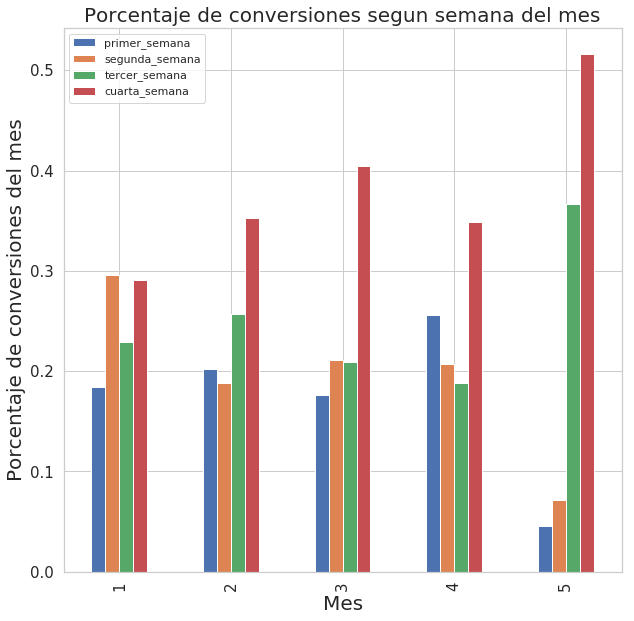

In [75]:
conversiones_por_semana_del_mes = conversiones_por_mes.drop(['month_week'], axis=1)
plot = conversiones_por_semana_del_mes.plot.bar(
    figsize=(10, 10), 
    fontsize=15,
)
plot.set_title("Porcentaje de conversiones segun semana del mes", fontsize=20)
plot.set_xlabel("Mes", fontsize=20)
plot.set_ylabel("Porcentaje de conversiones del mes", fontsize=20)

Si bien vemos una tendencia a la compra en la última semana del mes, hay que tener cuidado que en el quinto mes no se confunda con la posible campaña de marketing que se vio en el TP1 en donde la cantidad de eventos aumentaba ampliamente. Asumir que usuarios que realizan más eventos en la segunda quincena del mes es casi seguro que compren en junio sería peligroso.

Para ello recordemos cómo aumentaba la frecuencia de eventos según la semana del año.

In [83]:
events_count_per_week = eventos.week_year.value_counts()
events_count_per_week.sort_values(axis=0, ascending=True)
events_count_per_week = events_count_per_week.to_frame()
events_count_per_week['week'] = events_count_per_week.index
events_count_per_week.sort_values(by='week', inplace=True)
events_count_per_week

,week_year,week
1,6731,1
2,12122,2
3,12688,3
4,11537,4
5,16097,5
6,15323,6
7,15546,7
8,21058,8
9,28420,9
10,31867,10


Text(0,0.5,'Cantidad')

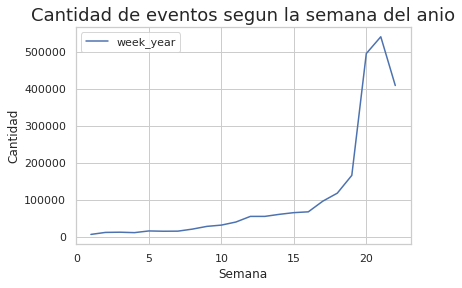

In [81]:
plot_events_per_week = events_count_per_week[['week_year']].plot.line()
plot_events_per_week.set_title("Cantidad de eventos segun la semana del anio", fontsize=18)
plot_events_per_week.set_xlabel("Semana")
plot_events_per_week.set_ylabel("Cantidad")

Vemos como justamente el mayor salto se da de la semana 19 a la semana 20 del año.
Cabe aclarar que la caída en el gráfico se debe a que de la última semana hay dos días de junio de los cuales no se tiene información.

La semana 19 del año empezó el 7 de mayo y la semana 20 empezó el 14 de mayo.

Aún así agregaremos el feature de "en qué semana del mes tiende a hacer más eventos el usuario".


In [85]:
eventos['cant_ev_primer_semana_mes'] = (eventos.month_week == 1).astype(int)
eventos['cant_ev_segunda_semana_mes'] = (eventos.month_week == 2).astype(int)
eventos['cant_ev_tercera_semana_mes'] = (eventos.month_week == 3).astype(int)
eventos['cant_ev_cuarta_semana_mes'] = (eventos.month_week == 4).astype(int)

df = eventos.groupby(['person']).agg({
    'cant_ev_primer_semana_mes': 'sum',
    'cant_ev_segunda_semana_mes': 'sum',
    'cant_ev_tercera_semana_mes': 'sum',
    'cant_ev_cuarta_semana_mes': 'sum'
})
df['semana_del_mes_moda'] = df.idxmax(axis=1)
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_primer_semana_mes'), 
    'semana_del_mes_moda'
] = 1
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_segunda_semana_mes'), 
    'semana_del_mes_moda'
] = 2
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_tercera_semana_mes'), 
    'semana_del_mes_moda'
] = 3
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_cuarta_semana_mes'), 
    'semana_del_mes_moda'
] = 4
usuarios_y_semana_del_mes_moda = df.reset_index()
usuarios_y_semana_del_mes_moda.head(10)

,person,cant_ev_cuarta_semana_mes,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,semana_del_mes_moda
0,0008ed71,0,0,0,6,3
1,00091926,95,44,121,188,3
2,00091a7a,10,0,0,0,4
3,000ba417,138,0,0,68,4
4,000c79fe,17,0,0,0,4
5,000e4d9e,196,0,0,215,3
6,000e619d,0,0,0,68,3
7,001001be,1,0,0,67,3
8,0010e89a,4,0,0,0,4
9,0016c4b5,4,0,0,0,4


In [86]:
usuarios_y_semana_del_mes_moda.semana_del_mes_moda.value_counts()

4    22233
3    12527
2     2440
1     1629
Name: semana_del_mes_moda, dtype: int64

In [88]:
user_features5 = user_features4.merge(usuarios_y_semana_del_mes_moda, how='inner', on='person')
user_features5
# user_features4.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_north,cant_accesos_center_west,cant_accesos_southeast,cant_accesos_south,cant_accesos_northeast,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_tarde,cant_ev_manana,cant_ev_noche,franja_horaria_moda,cant_muy_buenos,cant_excelentes,cant_nuevos,cant_buenos,condicion_de_producto_moda,cant_ev_cuarta_semana_mes,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,semana_del_mes_moda
0,4886f805,0,0,1,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada,1,4,0,0,excelentes,0,0,0,9,3
1,ad93850f,0,0,5,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada,7,4,0,10,buenos,7,0,13,45,3
2,0297fc1e,0,0,95,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,202,45,169,cant_ev_tarde,119,46,0,246,buenos,250,67,99,151,4
3,2d681dd8,0,0,2,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche,0,0,0,14,buenos,16,0,0,10,4
4,cccea85e,0,0,22,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,120,0,561,cant_ev_noche,347,191,1,201,muy buenos,270,104,213,249,4
5,4c8a8b93,0,0,20,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,81,2,67,cant_ev_madrugada,39,76,2,62,excelentes,2,0,0,255,3
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,0,2,15,cant_ev_noche,2,0,0,8,buenos,0,0,0,25,3
7,29ebb414,0,0,4,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,9,0,6,cant_ev_madrugada,3,4,0,2,excelentes,0,0,0,35,3
8,de8fe91b,0,0,2,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada,12,8,0,8,muy buenos,0,0,0,53,3
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada,0,0,0,7,buenos,0,0,0,20,3
